## Basic imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import log2
from tqdm import tqdm
from scipy.stats import kstest 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
plt.rcParams["figure.figsize"] = (9,9)
pd.set_option("display.max_columns", None)

In [3]:
# This only keeps non-error columns
df = pd.read_csv('KOI.csv')
predictor_list = []
error_list = []
for i in df.columns:
    if '2' in i or '1' in i:
        error_list.append(i)
    else:
        predictor_list.append(i)
predictor_list = predictor_list[1:]

#### Error Confidence Permutation Test

In [4]:
# This is formatting for doing permutation test.
error_df = df[error_list]
error_df['koi_disposition'] = df.koi_disposition
error_df.drop(['koi_teq_err1','koi_teq_err2' ],axis=1,inplace=True)
error_df.dropna(inplace=True)
new_names = 'koi_period koi_time0bk koi_impact koi_duration koi_depth koi_prad koi_insol koi_steff koi_slogg koi_srad'.split(' ')

error_df = pd.concat((error_df,pd.Series(error_df.iloc[:,0] - error_df.iloc[:,1],name=new_names[0]+'_error')),axis=1,)
error_df = pd.concat((error_df,pd.Series(error_df.iloc[:,2] - error_df.iloc[:,3],name=new_names[1]+'_error')),axis=1,)
error_df = pd.concat((error_df,pd.Series(error_df.iloc[:,4] - error_df.iloc[:,5],name=new_names[2]+'_error')),axis=1,)
error_df = pd.concat((error_df,pd.Series(error_df.iloc[:,6] - error_df.iloc[:,7],name=new_names[3]+'_error')),axis=1,)
error_df = pd.concat((error_df,pd.Series(error_df.iloc[:,8] - error_df.iloc[:,9],name=new_names[4]+'_error')),axis=1)
error_df = pd.concat((error_df,pd.Series(error_df.iloc[:,10] - error_df.iloc[:,11],name=new_names[5]+'_error')), axis=1)
error_df = pd.concat((error_df,pd.Series(error_df.iloc[:,12] - error_df.iloc[:,13],name=new_names[6]+'_error')), axis=1)
error_df = pd.concat((error_df,pd.Series(error_df.iloc[:,14] - error_df.iloc[:,15],name=new_names[7]+'_error')), axis=1)
error_df = pd.concat((error_df,pd.Series(error_df.iloc[:,16] - error_df.iloc[:,17],name=new_names[8]+'_error')), axis=1)
error_df = pd.concat((error_df,pd.Series(error_df.iloc[:,18] - error_df.iloc[:,19],name=new_names[9]+'_error')), axis=1)

error_df_test = error_df[error_df.koi_disposition == 'CANDIDATE']
error_df_train = error_df[error_df.koi_disposition != 'CANDIDATE']
def change(x):
    if x == 'CONFIRMED':
        return 1
    else:
        return 0
error_df_train['koi_disposition'] = error_df_train['koi_disposition'].apply(lambda x: change(x))

/home/gabenicholson/ipykernel_4054966/2329918464.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['koi_disposition'] = df.koi_disposition
/software/python-anaconda-2020.11-el8-x86_64/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/software/python-anaconda-2020.11-el8-x86_64/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

In [5]:
def permut_p_value(column_name, num_perm=15000):
    """ Permute Error Columns.
    """
    permutation_statistics = []
    original_statistic = np.abs(np.corrcoef(error_df_train.iloc[:,column_name], error_df_train['koi_disposition'])[1][0])

    for i in range(num_perm):
        shuffled_df = np.random.permutation(error_df_train['koi_disposition'])
        perm_statistic = np.corrcoef(error_df_train.iloc[:,column_name], shuffled_df)[1][0]
        permutation_statistics.append(perm_statistic)
    permutation_statistics = np.array(permutation_statistics)
    p_val = (1 + sum(np.abs(permutation_statistics) >= original_statistic))/(1 + num_perm)
    return np.around(p_val,4)


In [906]:
# Checks p value for the error columns interval. 
p_vals = {}
for col_name in range(21,31):
    p = permut_p_value(col_name)
    p_vals[error_df.columns[col_name]] = p
table = pd.DataFrame(pd.Series(p_vals), columns=['p-value'])
table.index.names = ['Error Variable Name']

In [907]:
table

,p-value
Error Variable Name,
koi_period_error,0.0001
koi_time0bk_error,0.0001
koi_impact_error,0.0001
koi_duration_error,0.0001
koi_depth_error,0.0935
koi_prad_error,0.0199
koi_insol_error,0.0001
koi_steff_error,0.0001
koi_slogg_error,0.0001


In [10]:
def ks_permut_p_value(column_name, num_perm=15000):
    """ 
    Permute using the KS test statistic.
    """
    permutation_statistics = []
    original_statistic = kstest(error_df_test[column_name], error_df_train[column_name])[1]
    for i in range(num_perm):
        shuffled_df = np.random.permutation(error_df[column_name])
        test_permutation = shuffled_df[:2163]
        train_permutation = shuffled_df[2163:]
        ks_statistic = kstest(test_permutation, train_permutation)[1]
        permutation_statistics.append(ks_statistic)
        
    permutation_statistics = np.array(permutation_statistics)
    p_val = (1 + sum(permutation_statistics <= original_statistic))/(1 + num_perm)
    return np.around(p_val,4)


In [7]:
error_df.columns[21:31]

Index(['koi_period_error', 'koi_time0bk_error', 'koi_impact_error',
       'koi_duration_error', 'koi_depth_error', 'koi_prad_error',
       'koi_insol_error', 'koi_steff_error', 'koi_slogg_error',
       'koi_srad_error'],
      dtype='object')

In [11]:
# Checks the KS p value for the error columns interval. 
p_vals = {}
for col_name in tqdm(error_df.columns[21:31]):
    p = ks_permut_p_value(col_name)
    p_vals[col_name] = p
    print(p_vals)w
table = pd.DataFrame(pd.Series(p_vals), columns=['p-value'])
table.index.names = ['Error Variable Name']

100%|████████████████████████████████████████| 10/10 [2:02:05<00:00, 732.53s/it]


In [12]:
table

,p-value
Error Variable Name,
koi_period_error,0.0001
koi_time0bk_error,0.0001
koi_impact_error,0.0001
koi_duration_error,0.0001
koi_depth_error,0.0001
koi_prad_error,0.0001
koi_insol_error,0.0001
koi_steff_error,0.0001
koi_slogg_error,0.0225


In [711]:
df = df[predictor_list] # This is when removing the error columns
df.drop(df.iloc[:,3:7].columns,axis=1,inplace=True) # Removes flag variables

<AxesSubplot:>

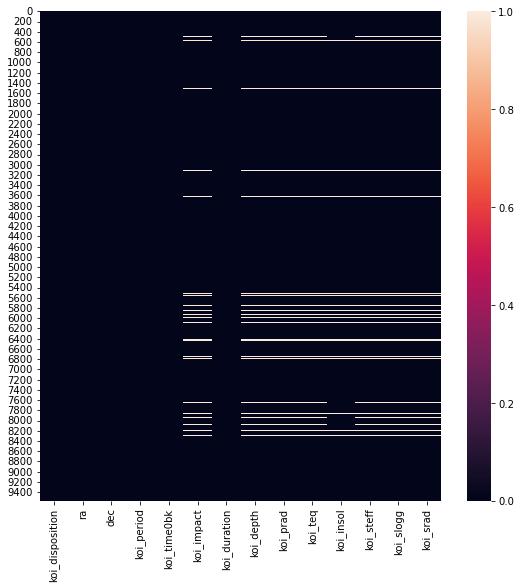

In [712]:
sns.heatmap(df.isna())

 **Lots of NA values.**

In [715]:
print(df[df.isnull()['koi_srad']]['koi_disposition'].value_counts());
print()
print(f'The proportion of False Positives: {np.around(299/(299+63),3)}')

FALSE POSITIVE    299
CANDIDATE          63
CONFIRMED           1
Name: koi_disposition, dtype: int64

The proportion of False Positives: 0.826


In [716]:
df.koi_disposition.value_counts()
proportion = 5023/(2293 + 5023)
print(f'The propotion of False Positives on training dataset {np.around(proportion,3)}')

The propotion of False Positives on training dataset 0.687


This shows that the proportion of False positives among the NA values is around 14% higher. 

In [717]:
df.dropna(inplace=True) # solution is to just drop them.

In [718]:
# Bit of an uneven distribution. 
df.koi_disposition.value_counts()

FALSE POSITIVE    4724
CONFIRMED         2292
CANDIDATE         2185
Name: koi_disposition, dtype: int64

High correlation values on (koi_Slogg,koi_Srad), (koi_prad, koi_impact).

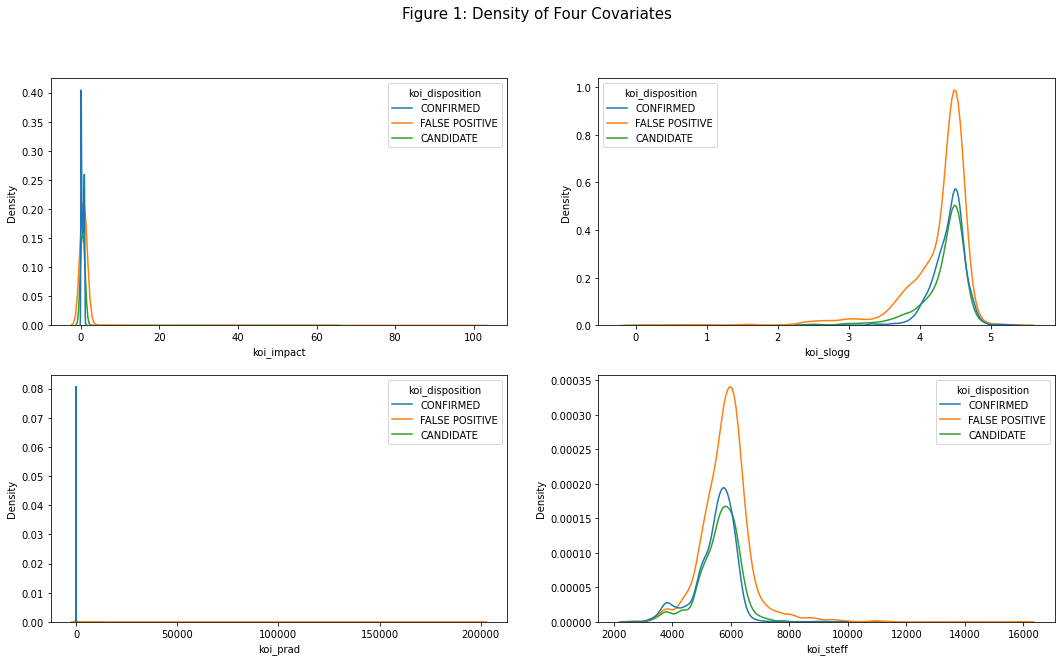

In [720]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

sns.kdeplot(df['koi_impact'], hue=df['koi_disposition'], ax=axes[0, 0])

# axes[0, 0].set_title(f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[0]],3)}')

sns.kdeplot(df['koi_slogg'], hue=df['koi_disposition'], ax=axes[0, 1])
# axes[0, 1].set_title(f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[1]],3)}')

sns.kdeplot(df['koi_prad'], hue=df['koi_disposition'], ax=axes[1, 0])
# axes[0, 2].set_title(f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[2]],3)}')

sns.kdeplot(df['koi_steff'], hue=df['koi_disposition'], ax=axes[1, 1])

plt.suptitle('Figure 1: Density of Four Covariates', fontsize=15)
plt.savefig('fig1.png')


In [723]:
from pprint import PrettyPrinter
from scipy.stats import kstest 
pp = PrettyPrinter(indent=4)

df_test = df[df.koi_disposition == 'CANDIDATE']
df_train = df[df.koi_disposition != 'CANDIDATE']
ks_tests = {}
for col in df.columns:
    dist_test = kstest(df_test[col], df_train[col])[1]
    ks_tests[col] = np.around(dist_test,4)
pp.pprint(ks_tests)

{   'dec': 0.0704,
    'koi_depth': 0.0,
    'koi_disposition': 1.0,
    'koi_duration': 0.0,
    'koi_impact': 0.0,
    'koi_insol': 0.0,
    'koi_period': 0.0,
    'koi_prad': 0.0,
    'koi_slogg': 0.1074,
    'koi_srad': 0.0282,
    'koi_steff': 0.0009,
    'koi_teq': 0.0,
    'koi_time0bk': 0.0,
    'ra': 0.0028}


### INFERENCE Full Conformal

In [728]:
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.decomposition import PCA
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
df = pd.read_csv('/Users/gabrielnicholson/Desktop/KOI.csv')

# This only keeps non-error columns
predictor_list = []
for i in df.columns:
    if '2' in i or '1' in i:
        pass
    else:
        predictor_list.append(i)

predictor_list = predictor_list[1:] # removing kepid
df = df[predictor_list] # This is when removing the error columns
df.drop(df.iloc[:,3:7].columns,axis=1,inplace=True) # Removes flag variables
df.dropna(inplace=True) # solution is to just drop them.
df.drop(['ra', 'dec'], axis=1, inplace=True)
df.drop('koi_insol', axis=1, inplace=True)

df_test = df[df.koi_disposition == 'CANDIDATE']
df_train = df[df.koi_disposition != 'CANDIDATE']
regular_df = df.copy()

X_train = df_train.drop('koi_disposition',axis=1).rank(pct=True)
X_test = df_test.drop('koi_disposition',axis=1).rank(pct=True)
all_X = df.drop('koi_disposition',axis=1).rank(pct=True)

all_X.reset_index(inplace=True, drop=True)  # Indexs get messed up after dropping koi_disposition.
X_test.reset_index(inplace=True, drop=True)
df.reset_index(inplace=True, drop=True)

df = pd.concat((df.koi_disposition,all_X),axis=1) # Put koi_disposition back after not giving it a rank.


In [729]:
# Creating PCA and K means using only the ranked X data. 
pca = PCA(n_components=5)
pca_transformed = pca.fit_transform(all_X)

kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=500, n_init=30, random_state=42)
df['cluster'] = kmeans.fit_predict(pca_transformed)
regular_df['cluster'] = kmeans.fit_predict(pca_transformed)

In [730]:
regular_df_train = regular_df[regular_df['koi_disposition'] != 'CANDIDATE' ]
regular_df_test = regular_df[regular_df['koi_disposition'] == 'CANDIDATE' ]
df_test = df[df.koi_disposition == 'CANDIDATE']

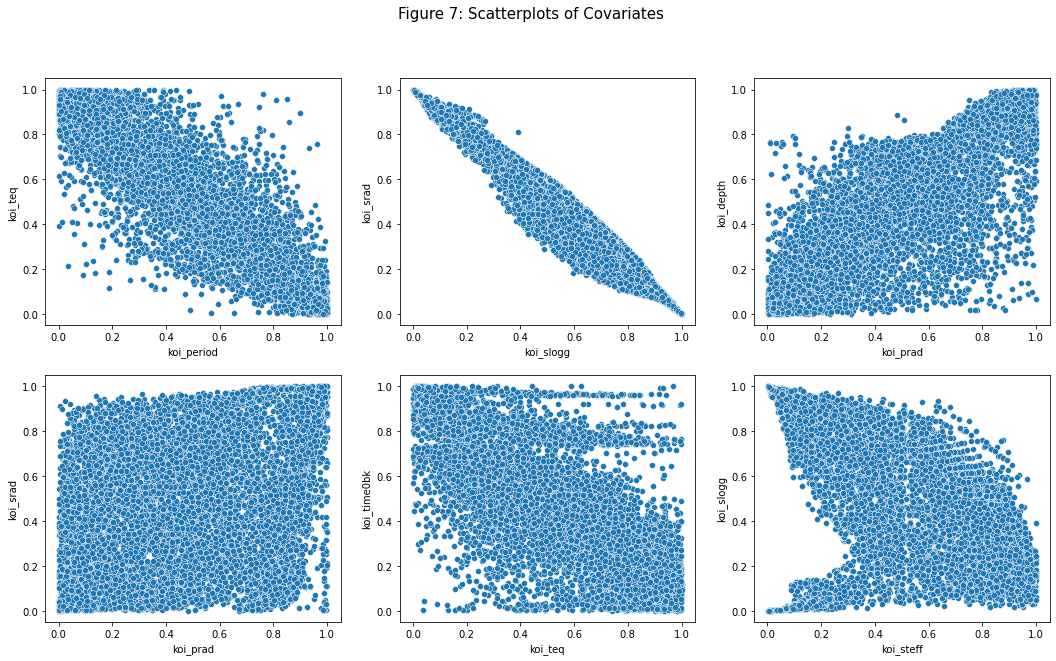

In [732]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

sns.scatterplot(ax=axes[0, 0], data=df, x = 'koi_period', y = 'koi_teq')

sns.scatterplot(ax=axes[0, 1], data=df, x = 'koi_slogg', y = 'koi_srad')

sns.scatterplot(ax=axes[0, 2], data=df, x = 'koi_prad', y = 'koi_depth')

sns.scatterplot(ax=axes[1, 0], data=df, x = 'koi_prad', y = 'koi_srad')

sns.scatterplot(ax=axes[1, 1], data=df, x = 'koi_teq', y = 'koi_time0bk')

sns.scatterplot(ax=axes[1, 2], data=df, x = 'koi_steff', y = 'koi_slogg')

plt.suptitle('Figure 7: Scatterplots of Covariates', fontsize=15)

plt.savefig('fig7.png')


In [733]:
X_test = df_test.drop(['koi_disposition', 'cluster'],axis=1).rank(pct=True)
X_test.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

test_df = pd.concat((X_test, df_test[['koi_disposition', 'cluster']]),axis=1)

# Calculates information needed for clustering
num_train_clusters = df[df.koi_disposition != 'CANDIDATE']['cluster'].value_counts()
num_test_clusters = df[df.koi_disposition == 'CANDIDATE']['cluster'].value_counts()

train_cluster_len = [num_train_clusters[i] for i in range(len(num_train_clusters))] # The indexes are in order of cluster.
test_cluster_len = [num_test_clusters[i] for i in range(len(num_test_clusters))] # The indexes are in order of cluster.

total_train_clus = np.sum(train_cluster_len)
total_test_clus = np.sum(test_cluster_len)

In [734]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(df.drop(['koi_disposition', 'cluster'],axis=1))
print(f'chi_square_value: {chi_square_value}')
print(f'p_value: {p_value}')

chi_square_value: 97803.2245377728
p_value: 0.0


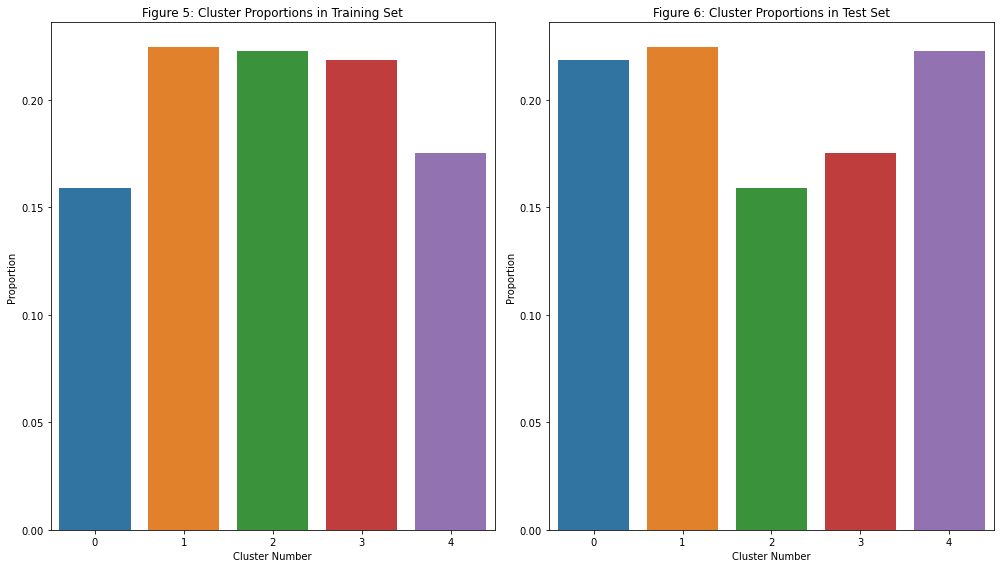

In [735]:
plt_train_clusters = df[df.koi_disposition != 'CANDIDATE']['cluster'].value_counts(normalize=True)
plt_test_clusters = df[df.koi_disposition == 'CANDIDATE']['cluster'].value_counts(normalize=True)

fig, axs = plt.subplots(ncols=2, figsize=(14,8))
fig = sns.barplot(x = plt_train_clusters.index, y = plt_train_clusters, ax=axs[0])
fig.set_title('Figure 5: Cluster Proportions in Training Set')
fig.set_ylabel('Proportion')
fig.set_xlabel('Cluster Number')

fig = sns.barplot(x = plt_test_clusters.index, y = plt_train_clusters, ax=axs[1])
fig.set_title('Figure 6: Cluster Proportions in Test Set')
fig.set_ylabel('Proportion')
fig.set_xlabel('Cluster Number')
plt.tight_layout()
plt.savefig('figure 5 & 6')

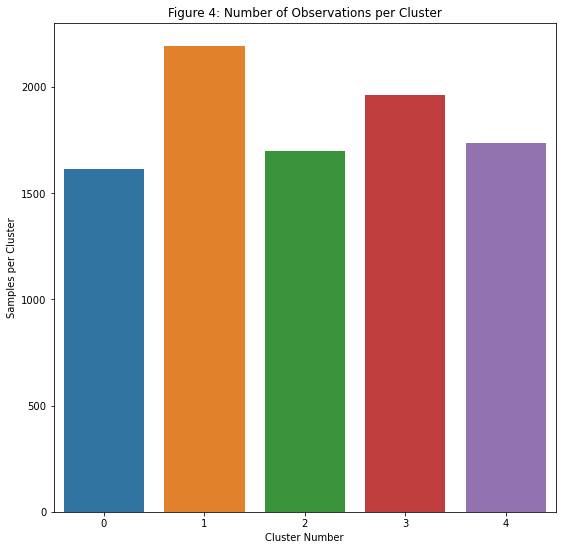

In [742]:
sns.barplot(x=df.cluster.value_counts(sort=False).index, y=df.cluster.value_counts(sort=False))
plt.ylabel('Samples per Cluster')
plt.title('Figure 4: Number of Observations per Cluster')
plt.xlabel('Cluster Number')
plt.savefig('fig4')

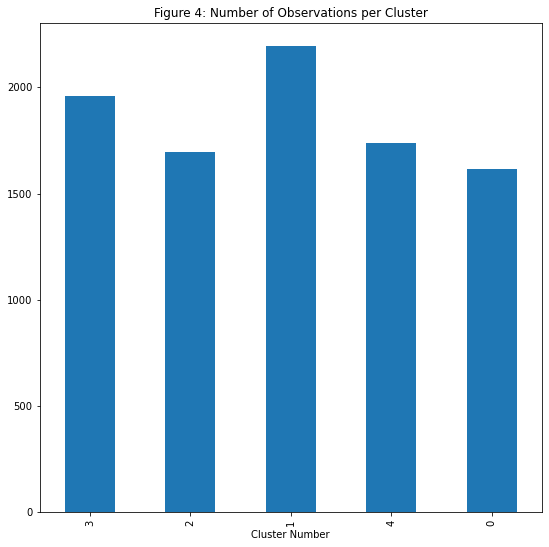

In [686]:
df.cluster.value_counts(sort=False).plot.bar()


In [724]:
def full_conformal(test_row, cp_df_train, alpha):
    """ Our main algorithm.
    """
    cp_conformal_df = cp_df_train.append(test_row) # appends the test row to the bottom  of training data
    X = cp_conformal_df.drop(['koi_disposition', 'cluster'], axis=1)
    y = cp_conformal_df['koi_disposition']

    # Calculates the denominator.
    test_clust = test_row.cluster
    denominator = 7015.999999999839
    q_test =  test_cluster_len[test_clust] / total_test_clus
    q_train = train_cluster_len[test_clust] / total_train_clus
    denominator += (q_test/q_train)
    
    # Calculates the weights for each cluster.
    weights = []
    for c_num in cp_conformal_df.cluster:
        q_test =  test_cluster_len[c_num] / total_test_clus
        q_train = train_cluster_len[c_num] / total_train_clus
        weight_i = (q_test / q_train) / (denominator)
        weights.append(weight_i)

    y.iloc[-1] = 'CONFIRMED'        # Put in the guessed value for y. 
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    model_confirmed = LogisticRegression(max_iter=1000, C=100)
    model_confirmed.fit(X, y)

    y.iloc[-1] = 'FALSE POSITIVE'   # Put in the guessed value for y. 
    model_false_positive = LogisticRegression(max_iter=1000, C=100)
    model_false_positive.fit(X, y)

    scores_confirmed = 1/(model_confirmed.predict_proba(X)[:,0] + 0.00001)
    scores_fp = 1/(model_false_positive.predict_proba(X)[:,1] + 0.00001)

    # Keeps track of score on test sample.
    TEST_SCORE_confirmed = scores_confirmed[-1]
    TEST_SCORE_FP = scores_fp[-1]

    confirmed_df = pd.DataFrame({'Scores of Confirmed':scores_confirmed, 'Weights':weights})
    false_positive_df =  pd.DataFrame({'false positive score':scores_fp, 'Weights':weights})

    confirmed_df.sort_values(by='Scores of Confirmed',inplace=True)
    false_positive_df.sort_values(by='false positive score',inplace=True)

    confirmed_df['weight_cdf'] = np.cumsum(confirmed_df['Weights'])
    false_positive_df['weight_cdf'] = np.cumsum(false_positive_df['Weights'])

    # Checking if the score is within the 1-alpha weight quantile.
    prediction_set = []
    score_Q_confirmed = confirmed_df[confirmed_df['weight_cdf'] <= (1-alpha)]['Scores of Confirmed'].iloc[-1]
    score_Q_false_positive = false_positive_df[false_positive_df['weight_cdf'] <= (1-alpha)]['false positive score'].iloc[-1]

    if TEST_SCORE_confirmed < score_Q_confirmed:
        prediction_set.append('CONFIRMED')

    if TEST_SCORE_FP < score_Q_false_positive:
        prediction_set.append('FALSE POSITIVE')
    
    return prediction_set, confirmed_df

In [725]:
regular_df_test.reset_index(drop=True,inplace=True)
regular_df_train.reset_index(drop=True,inplace=True)

In [701]:
denominator = 0 
for c_num in regular_df_train.cluster:
    q_test =  test_cluster_len[c_num] / total_test_clus
    q_train = train_cluster_len[c_num] / total_train_clus
    denominator += (q_test/q_train)
denominator

7015.999999999839

In [702]:
predictions = []
cp_df_train = regular_df_train.copy() #9:31

for row in tqdm(range(len(regular_df_test))):
    prediction_set, confirmed_df = full_conformal(test_row=regular_df_test.iloc[row], cp_df_train=cp_df_train, alpha=0.1)
    predictions.append(prediction_set) 

  5%|▌         | 114/2185 [00:29<08:50,  3.90it/s]


KeyboardInterrupt: 

In [ ]:
both = 0
false_pos_single = 0
confirmed_single = 0
crazy_case_nothing_in_set = 0
for lst in predictions:
    if len(lst) == 2:
        both += 1
    elif len(lst) == 1:
        if lst == 'CONFIRMED':
            confirmed_single += 1
        else:
            false_pos_single += 1
    else:
        crazy_case_nothing_in_set += 1

print(f'both: {both/len(predictions)}')
print(f'false_pos_single: {false_pos_single/len(predictions)}')
print(f'confirmed_single: {confirmed_single/len(predictions)}')
print(f'crazy_case_nothing_in_set: {crazy_case_nothing_in_set/len(predictions)}')

both: 0.8320366132723113
false_pos_single: 0.1679633867276888
confirmed_single: 0.0
crazy_case_nothing_in_set: 0.0


In [726]:
# c = 0
# for i in predictions:
#     c+= len(i)
# c

### Simulating Data

In [514]:
from numpy import dot
from numpy.linalg import norm

pca_training = pca_transformed[np.where(df.koi_disposition != 'CANDIDATE')]
pca_test = pca_transformed[np.where(df.koi_disposition == 'CANDIDATE')]

pca_transformed # Find the indexs for training and test

array([[-0.18623403,  0.23894612, -0.05993808,  0.3203594 ,  0.04502604],
       [-0.55184595,  0.06672517,  0.06360989,  0.03468027,  0.10053628],
       [-0.37012132,  0.09385694,  0.4909558 , -0.07811269,  0.28434044],
       ...,
       [ 0.67590271,  0.22598731, -0.56058212, -0.01232081, -0.2342279 ],
       [ 0.93073278,  0.26110155, -0.31497958,  0.07606314, -0.08133098],
       [ 0.477381  , -0.04713742, -0.5955417 , -0.05010942, -0.1094488 ]])

In [528]:
Z_list = []
p_bar = np.mean(pca_test,axis=0) - np.mean(pca_training,axis=0)

for i in range(len(pca_transformed)):
    p_i = pca_transformed[i]
    probability_i = ((dot(p_i, p_bar)/(norm(p_i)*norm(p_bar))) + 1) / 8
    Z_list.append(probability_i)
Z_list = np.random.binomial(n=1, p=Z_list)

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [530]:
all_xs = regular_df.drop(['koi_disposition','cluster'],axis=1)

In [531]:
scaler = StandardScaler()
all_xs = scaler.fit_transform(all_xs)

In [532]:
simulated_y = {} # Using dictionary to keep track of index for concattinating with main dataframe.
for num, Z in enumerate(Z_list):
    if Z == 0:
        y_i = np.random.binomial(n=1,p=sigmoid(np.sum(all_xs[num])))
        simulated_y[num] = y_i
    else:
        y_i = np.random.binomial(n=1,p=0.5) 
        simulated_y[num] = y_i

In [533]:
regular_df.reset_index(drop=True,inplace=True)
sim_df = pd.concat((pd.Series(simulated_y, name='simulated_y'),regular_df),axis=1)

### Running Simulations

In [534]:
sim_df.simulated_y.value_counts()

0    5064
1    4137
Name: simulated_y, dtype: int64

In [621]:
def full_conformal(test_row, cp_df_train, alpha):
    cp_conformal_df = cp_df_train.append(test_row) # appends the test row to the bottom  of training data
    X = cp_conformal_df.drop(['koi_disposition', 'cluster', 'simulated_y'], axis=1)
    y = cp_conformal_df['simulated_y']

    # Calculates the denominator.
    test_clust = test_row.cluster
    denominator = 7015.999999999839
    q_test =  test_cluster_len[test_clust] / total_test_clus
    q_train = train_cluster_len[test_clust] / total_train_clus
    denominator += (q_test/q_train)
    
    # Calculates the weights for each cluster.
    weights = []
    for c_num in cp_conformal_df.cluster:
        q_test =  test_cluster_len[c_num] / total_test_clus
        q_train = train_cluster_len[c_num] / total_train_clus
        weight_i = (q_test / q_train) / (denominator)
        weights.append(weight_i)
    
    # weights = np.ones(len(cp_conformal_df.cluster)) * 1/len(cp_conformal_df.cluster)

    y.iloc[-1] = 0     # Put in the guessed value for y. 
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    model_confirmed = LogisticRegression(max_iter=1000, C=100)
    model_confirmed.fit(X, y)

    y.iloc[-1] = 1   # Put in the guessed value for y. 
    model_false_positive = LogisticRegression(max_iter=1000, C=100)
    model_false_positive.fit(X, y)

    scores_confirmed = 1/(model_confirmed.predict_proba(X)[:,0] + 0.00001)
    scores_fp = 1/(model_false_positive.predict_proba(X)[:,1] + 0.00001)

    # Keeps track of score on test sample.
    TEST_SCORE_confirmed = scores_confirmed[-1]
    TEST_SCORE_FP = scores_fp[-1]

    confirmed_df = pd.DataFrame({'Scores of Confirmed':scores_confirmed, 'Weights':weights})
    false_positive_df =  pd.DataFrame({'false positive score':scores_fp, 'Weights':weights})

    confirmed_df.sort_values(by='Scores of Confirmed',inplace=True)
    false_positive_df.sort_values(by='false positive score',inplace=True)

    confirmed_df['weight_cdf'] = np.cumsum(confirmed_df['Weights'])
    false_positive_df['weight_cdf'] = np.cumsum(false_positive_df['Weights'])

    # Checking if the score is within the 1-alpha weight quantile.
    prediction_set = []
    score_Q_confirmed = confirmed_df[confirmed_df['weight_cdf'] <= (1-alpha)]['Scores of Confirmed'].iloc[-1]
    score_Q_false_positive = false_positive_df[false_positive_df['weight_cdf'] <= (1-alpha)]['false positive score'].iloc[-1]

    if TEST_SCORE_confirmed < score_Q_confirmed:
        prediction_set.append('CONFIRMED')

    if TEST_SCORE_FP < score_Q_false_positive:
        prediction_set.append('FALSE POSITIVE')
    
    return prediction_set, confirmed_df

In [617]:
all_X # should be percentile.

,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_steff,koi_slogg,koi_srad
0,0.504402,0.752853,0.207640,0.348169,0.596674,0.475166,0.441908,0.311216,0.564178,0.397185
1,0.794588,0.717857,0.532714,0.593414,0.673405,0.569449,0.179491,0.311216,0.564178,0.397185
2,0.656450,0.808608,0.829258,0.124878,0.849364,0.748071,0.325345,0.571297,0.752310,0.311923
3,0.179220,0.748723,0.971416,0.241822,0.838604,0.834420,0.754266,0.537659,0.804749,0.191229
4,0.240409,0.769373,0.614988,0.102380,0.591784,0.559722,0.758124,0.685849,0.498044,0.566732
...,...,...,...,...,...,...,...,...,...,...
9196,0.485165,0.133138,0.664547,0.627323,0.130203,0.149658,0.532062,0.420172,0.307521,0.611510
9197,0.010651,0.052060,0.950929,0.397674,0.757092,0.817629,0.906532,0.420172,0.716661,0.365286
9198,0.179437,0.275840,0.106130,0.377296,0.051625,0.041191,0.812575,0.754211,0.515161,0.550429
9199,0.046517,0.173351,0.208401,0.013694,0.155309,0.136507,0.923487,0.786328,0.521193,0.561298


In [622]:
pca = PCA(n_components=5)
pca_transformed = pca.fit_transform(all_X)

kmeans = KMeans(n_clusters=20, init='k-means++', max_iter=500, n_init=30, random_state=42)
df['cluster'] = kmeans.fit_predict(pca_transformed)
regular_df['cluster'] = kmeans.fit_predict(pca_transformed)

regular_df.reset_index(drop=True,inplace=True)
sim_df = pd.concat((pd.Series(simulated_y, name='simulated_y'),regular_df),axis=1)

simulated_df_test = sim_df[sim_df.koi_disposition == 'CANDIDATE']
cp_df_train = sim_df.copy() 

num_train_clusters = df[df.koi_disposition != 'CANDIDATE']['cluster'].value_counts()
num_test_clusters = df[df.koi_disposition == 'CANDIDATE']['cluster'].value_counts()

train_cluster_len = [num_train_clusters[i] for i in range(len(num_train_clusters))] # The indexes are in order of cluster.
test_cluster_len = [num_test_clusters[i] for i in range(len(num_test_clusters))] # The indexes are in order of cluster.

total_train_clus = np.sum(train_cluster_len)
total_test_clus = np.sum(test_cluster_len)

predictions = []
for row in tqdm(range(len(simulated_df_test))):
    prediction_set, confirmed_df = full_conformal(test_row=simulated_df_test.iloc[row], cp_df_train=cp_df_train, alpha=0.1)
    predictions.append(prediction_set) 

100%|██████████| 2185/2185 [02:09<00:00, 16.85it/s]


In [623]:
where_suck = []
coverage=0

def change_simulated_test_var_name(x):
        if x == 0:
            return 'CONFIRMED'
        else:
            return 'FALSE POSITIVE'

check = simulated_df_test['simulated_y'].apply(lambda x: change_simulated_test_var_name(x))
for i in range(len(predictions)):
    if check.iloc[i] in predictions[i]:
        coverage += 1
    else:
        where_suck.append(check.iloc[i])


In [624]:
final_clust = len([i for i in predictions if len(i)<=1])/len(predictions) # zero clusters
final_clust_cov = coverage/len(predictions) 

In [591]:
zero_clust = len([i for i in predictions if len(i)<=1])/len(predictions) # zero clusters
zero_clust_cov = coverage/len(predictions) 

In [581]:
plot_coverage = []
plot_power = []
total_predictions = []

for i in range(2,21):
    pca = PCA(n_components=5)
    pca_transformed = pca.fit_transform(all_X)

    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=30, random_state=42)
    df['cluster'] = kmeans.fit_predict(pca_transformed)
    regular_df['cluster'] = kmeans.fit_predict(pca_transformed)

    regular_df.reset_index(drop=True,inplace=True)
    sim_df = pd.concat((pd.Series(simulated_y, name='simulated_y'),regular_df),axis=1)

    simulated_df_test = sim_df[sim_df.koi_disposition == 'CANDIDATE']
    cp_df_train = sim_df.copy() 

    num_train_clusters = df[df.koi_disposition != 'CANDIDATE']['cluster'].value_counts()
    num_test_clusters = df[df.koi_disposition == 'CANDIDATE']['cluster'].value_counts()

    train_cluster_len = [num_train_clusters[i] for i in range(len(num_train_clusters))] # The indexes are in order of cluster.
    test_cluster_len = [num_test_clusters[i] for i in range(len(num_test_clusters))] # The indexes are in order of cluster.

    total_train_clus = np.sum(train_cluster_len)
    total_test_clus = np.sum(test_cluster_len)

    predictions = []
    for row in tqdm(range(len(simulated_df_test))):
        prediction_set, confirmed_df = full_conformal(test_row=simulated_df_test.iloc[row], cp_df_train=cp_df_train, alpha=0.1)
        predictions.append(prediction_set) 

    def kk(x):
        if x == 0:
            return 'CONFIRMED'
        else:
            return 'FALSE POSITIVE'
    check = simulated_df_test['simulated_y'].apply(lambda x: kk(x))

    coverage = 0
    where_suck = []
    for i in range(len(predictions)):
        if check.iloc[i] in predictions[i]:
            coverage += 1
        else:
            where_suck.append(check.iloc[i])
            
    total_predictions.append(predictions)
    plot_coverage.append(coverage/len(check))
    plot_power.append(len([i for i in predictions if len(i)<=1])/len(predictions))

100%|██████████| 2185/2185 [02:16<00:00, 15.96it/s]


In [625]:
plot_coverage.append(final_clust)
plot_power.append(final_clust_cov)

In [594]:
plot_coverage.insert(0, zero_clust_cov)

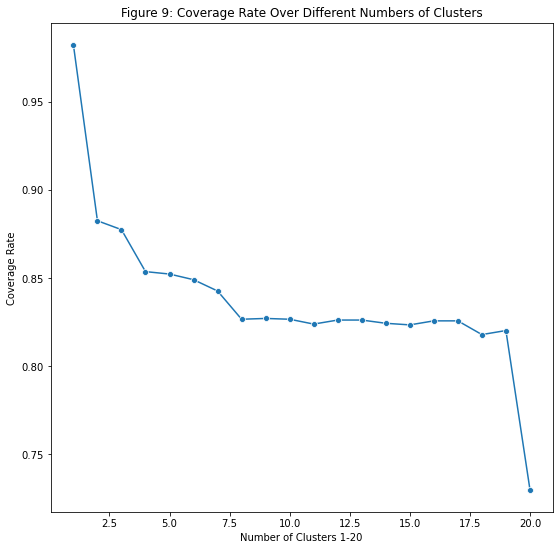

In [670]:
sns.lineplot(x=np.arange(1,21), y=plot_coverage, marker='o')
plt.title('Figure 9: Coverage Rate Over Different Numbers of Clusters')
plt.xlabel('Number of Clusters 1-20')
plt.ylabel('Coverage Rate')
plt.savefig('fig9')

In [605]:
plot_power.insert(0, zero_clust)

22

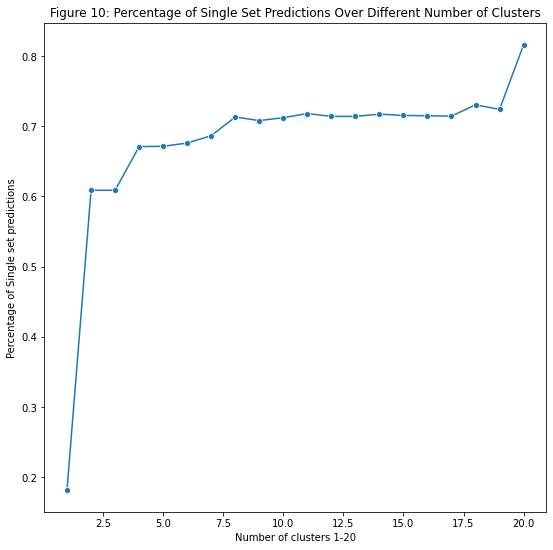

In [672]:
sns.lineplot(x=np.arange(1,21), y=plot_power, marker='o')
plt.title('Figure 10: Percentage of Single Set Predictions Over Different Number of Clusters')
plt.ylabel('Percentage of Single set predictions')
plt.xlabel('Number of clusters 1-20')
plt.savefig('fig10')

### Verifying K-Means and PCA

In [228]:
all = all_X.copy()

In [229]:
# Or fit on all the data.
pca = PCA(n_components=5)
all = pca.fit_transform(all)
pca.explained_variance_ratio_.sum() # 5 components can explain 91% variance. 

0.9106992325061034

In [230]:
pca_train = all[np.where(df.koi_disposition != 'CANDIDATE')]
pca_test = all[np.where(df.koi_disposition == 'CANDIDATE')]

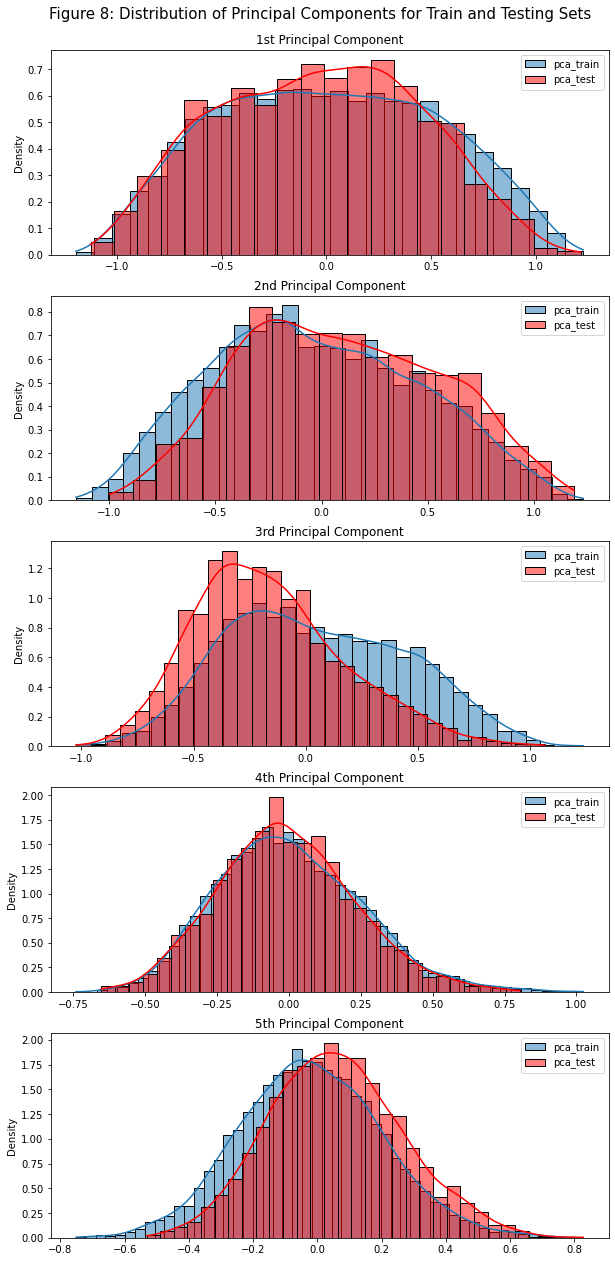

In [677]:
fig, axs = plt.subplots(nrows=5, figsize=(10,20))


sns.histplot(pca_train[:,0], label='pca_train', ax=axs[0], kde=True, stat='density')
sns.histplot(pca_test[:,0], color='r', label='pca_test', ax=axs[0], kde=True,stat='density')
axs[0].set_title('1st Principal Component')
sns.histplot(pca_train[:,1], label='pca_train', ax=axs[1], kde=True,stat='density')
sns.histplot(pca_test[:,1], color='r', label='pca_test', kde=True,ax=axs[1], stat='density')
axs[1].set_title('2nd Principal Component')
sns.histplot(pca_train[:,2], label='pca_train', ax=axs[2], kde=True,stat='density')
sns.histplot(pca_test[:,2], color='r', label='pca_test', kde=True,ax=axs[2], stat='density')
axs[2].set_title('3rd Principal Component')
sns.histplot(pca_train[:,3], label='pca_train', ax=axs[3], kde=True,stat='density')
sns.histplot(pca_test[:,3], color='r', label='pca_test', ax=axs[3], kde=True,stat='density')
axs[3].set_title('4th Principal Component')
sns.histplot(pca_train[:,4], label='pca_train', ax=axs[4], kde=True, stat='density')
sns.histplot(pca_test[:,4], color='r', label='pca_test', ax=axs[4], kde=True, stat='density')
axs[4].set_title('5th Principal Component')
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
axs[4].legend()

fig.subplots_adjust(top=0.95)
plt.suptitle('Figure 8: Distribution of Principal Components for Train and Testing Sets', fontsize=15)
plt.savefig('fig8')


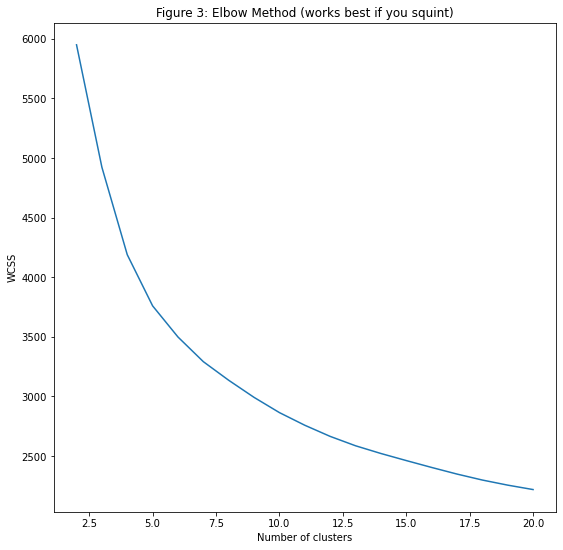

In [206]:
max_clusters = 20

wcss = []
for i in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=25, random_state=42)
    kmeans.fit(all_X)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, max_clusters + 1), wcss)
plt.title('Figure 3: Elbow Method (works best if you squint)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('figure 3')

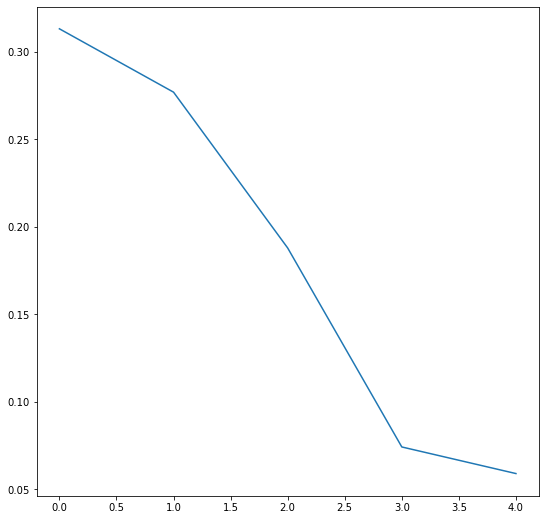

In [274]:
plt.plot(pca.explained_variance_ratio_)

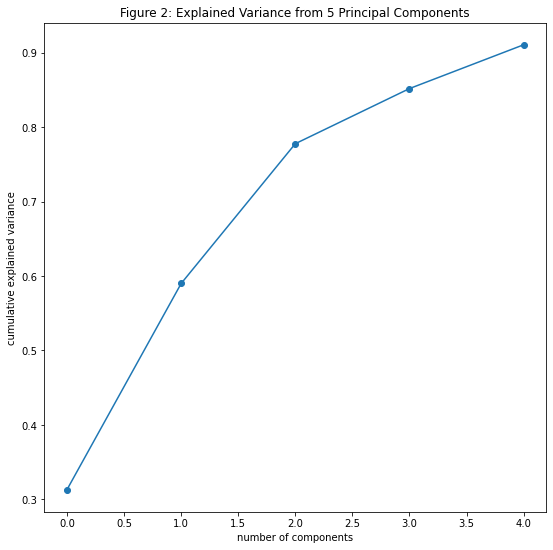

In [205]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title('Figure 2: Explained Variance from 5 Principal Components')
plt.savefig('fig2')

### Logit Regression

In [124]:
from sklearn.linear_model import LogisticRegression
from statsmodels.tools.tools import add_constant
from statsmodels.discrete.discrete_model import Logit

In [125]:
X = regular_df_train.drop(['koi_disposition', 'cluster'], axis=1)
y = pd.get_dummies(regular_df_train['koi_disposition'],drop_first=True).to_numpy()
X = add_constant(X)
model = Logit(y,X).fit()

Optimization terminated successfully.
         Current function value: 66.242443
         Iterations 15


/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [126]:
results_summary = model.summary()
print(results_summary)

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 7016
Model:                          Logit   Df Residuals:                     7005
Method:                           MLE   Df Model:                           10
Date:                Wed, 16 Mar 2022   Pseudo R-squ.:                     inf
Time:                        10:56:28   Log-Likelihood:            -4.6476e+05
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -26.7236      2.145    -12.459      0.000     -30.927     -22.520
koi_period       0.0167      0.001     19.836      0.000       0.015       0.018
koi_time0bk     -0.0028      0.001     -3.02

/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:3500: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


# Permutation test for distribution check

#### Permutation tests

In [313]:
from scipy.stats import ttest_ind
from scipy.stats import median_test

In [314]:
t_test_p_vals = {}
for col in df_train.columns[1:]:
    p_val = ttest_ind(df_test[col], df_train[col],permutations=20000, equal_var=False)[1]
    t_test_p_vals[col] = p_val

In [315]:
pp.pprint(t_test_p_vals) # Equal variance = False

{   'dec': 0.35305,
    'koi_depth': 0.0,
    'koi_duration': 0.0,
    'koi_impact': 0.0,
    'koi_insol': 0.0,
    'koi_period': 0.0063,
    'koi_prad': 0.0,
    'koi_slogg': 0.5487,
    'koi_srad': 0.3019,
    'koi_steff': 0.00185,
    'koi_teq': 0.0,
    'koi_time0bk': 0.20385,
    'ra': 0.0105}


In [162]:
pp.pprint(t_test_p_vals) # Equal variance assumption = True

{   'dec': 0.0778,
    'koi_depth': 0.0,
    'koi_duration': 0.0,
    'koi_impact': 0.00265,
    'koi_insol': 0.47005,
    'koi_period': 0.0,
    'koi_prad': 0.0897,
    'koi_slogg': 0.00855,
    'koi_srad': 0.15415,
    'koi_steff': 0.0,
    'koi_teq': 0.0,
    'koi_time0bk': 0.0002,
    'ra': 0.00215}


In [180]:
def permut_p_value(column_name, num_perm=15000, variance=False):
    """ 
    """
    permutation_statistics = []
    if variance:
        original_statistic = np.var(df_test[column_name])
        for i in range(num_perm):
            permutation = np.random.permutation(df[column_name])[:2185]
            variance_of_permutation = np.var(permutation)
            permutation_statistics.append(variance_of_permutation)
    else:
        stat, p, med, tbl = median_test(df_test[column_name], df_train[column_name])
        original_statistic = np.abs(stat)
        for i in range(num_perm):
            permutation_set = np.random.permutation(df[column_name])
            test_set = permutation_set[:2185]
            train_set = permutation_set[2185:]
            stat,perm_stat,_,_ = median_test(test_set, train_set)
            permutation_statistics.append(stat)
    permutation_statistics = np.array(permutation_statistics)

    p_val = 1 + sum(np.abs(permutation_statistics) >= original_statistic)/(num_perm - 1) # Is there a one minus in denominator?
    return p_val


In [391]:
def permut_p_value(column_name, num_perm=15000):
    """ 
    Permute using the KS test statistic.
    """
    permutation_statistics = []
    original_statistic = kstest(df_test[column_name], df_train[column_name])[1]
    for i in range(num_perm):
        shuffled_df = np.random.permutation(df[column_name])
        test_permutation = shuffled_df[:2185]
        train_permutation = shuffled_df[2185:]
        ks_statistic = kstest(test_permutation, train_permutation)[1]
        permutation_statistics.append(ks_statistic)
    permutation_statistics = np.array(permutation_statistics)

    p_val = (1 + sum(permutation_statistics <= original_statistic))/(num_perm)
    return np.around(p_val,4)


In [392]:
p_values_permut = {}
for col in tqdm(df.columns[1:]):
    p_val = permut_p_value(col)
    p_values_permut[col] = p_val

100%|██████████| 17/17 [1:04:52<00:00, 228.99s/it]


In [395]:
pd.Series(p_values_permut).to_csv('p_values.csv')

In [396]:
pd.read_csv('p_values.csv')

,Unnamed: 0,0
0,ra,0.0022
1,dec,0.0725
2,koi_fpflag_nt,0.0001
3,koi_fpflag_ss,0.0001
4,koi_fpflag_co,0.0001
5,koi_fpflag_ec,0.0001
6,koi_period,0.0001
7,koi_time0bk,0.0001
8,koi_impact,0.0001
9,koi_duration,0.0001
